In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *
from chase.cpt import w_prelec

from scipy.stats import norm
from scipy.stats.mstats import mquantiles

import pickle

def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

problems_str = {0: '4 w/ .8\nvs. 3',
                1: '-3 vs.\n-32 w/ .1',
                2: '-3 vs.\n-4 w/ .8',
                3: '32 w/ .1\nvs. 3',
                4: '32 w/ .025\nvs. 3 w/ .25',
                5: '3 vs.\n5 w/ .55',
                6: '4 w/ .9\nvs. 11 w/ .35',
                7: '-32 w/ .1\nvs. -12 w/ .25',
                8: '-3 w/ .35\nvs. -4 w/ .25'}

In [61]:
#FIGDEST = '/Users/markant/code/chase_paper/figures'
FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/CHASE Paper/figures'

# compile data

In [39]:
probdf = pd.read_csv('paper/data/frey2014/Frey14_ProblemTable_152.0.txt', sep=' ').reset_index()

In [40]:
Hind = {}
problems = {}

for i, row in probdf.iterrows():

    A = row[['outA1', 'probA1', 'outA2', 'probA2']].values.reshape(2,2)
    B = row[['outB1', 'probB1', 'outB2', 'probB2']].values.reshape(2,2)
    
    ev_A, ev_B = expected_value(np.array([A, B]))
    if ev_A > ev_B:
        Hind[i] = 0
        problems[i] = np.array([B, A], dtype=float)
    else:
        Hind[i] = 1
        problems[i] = np.array([A, B], dtype=float)

In [41]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('paper/data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('paper/data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat['group'] = grp
    arr.append(sampdat)

df = pd.concat(arr)

In [42]:
df.groupby(['subject']).apply(lambda d: np.sum(d.option==1)/float(d.shape[0])).values.mean()

0.49646370193780309

In [182]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('paper/data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('paper/data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat = sampdat.groupby(['subject', 'problem']).apply(lambda d: d.shape[0]).reset_index()
    sampdat.columns = ['subject', 'problem', 'samplesize']
    
    arr.append(pd.merge(dat, sampdat, on=['subject', 'problem']))
    
data = pd.concat(arr).reset_index()
data['problem'] = data['problem'] - 1
data.drop('index', axis=1, inplace=True)

# recode choices as L/H
arr = []
for i, row in data.iterrows():
    probid = row['problem']
    arr.append(1*(row['choice'] == Hind[probid]))
data['choice'] = np.array(arr)

data.to_csv('paper/data/frey2014/frey2014_data.csv')

In [43]:
data = pd.read_csv('paper/data/frey2014/frey2014_data.csv', index_col=0)

In [44]:
data.samplesize.min(), data.samplesize.max()

(2, 369)

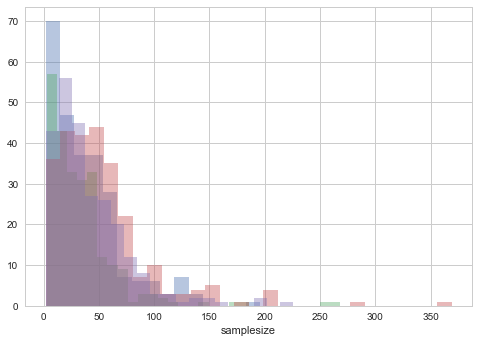

In [10]:
sns.distplot(data[data.group=='angry']['samplesize'], kde=False)
sns.distplot(data[data.group=='happy']['samplesize'], kde=False)
sns.distplot(data[data.group=='fearful']['samplesize'], kde=False)
sns.distplot(data[data.group=='sad']['samplesize'], kde=False)

# Fit FHR14

In [123]:
data = data[(data.group=='happy') | (data.group=='fearful')]

In [154]:
SIM_ID = 'process_FHR14'
OUTDIR = 'process_fitresults_FHR14'

FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}


PARSETS = [['tau', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain',
            'prelec_elevation', 'prelec_gamma',
            'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain',
            'prelec_elevation(group=happy)', 'prelec_gamma(group=happy)',
            'prelec_elevation(group=fearful)', 'prelec_gamma(group=fearful)',
            'theta(group=happy)', 'theta(group=fearful)']
]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [ ]:
for fitting in PARSETS:
        
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [155]:
for fitting in PARSETS:
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    print best

index                                                                   0
Unnamed: 0                                                              0
iteration                                                               0
success                                                              True
nllh                                                              2883.72
k                                                                       3
N                                                                     504
bic                                                               5786.11
tau                                                               9.96725
theta(group=fearful)                                              35.5306
theta(group=happy)                                                28.7019
sim_id                  process_FHR14(tau,theta(group=fearful),theta(g...
Name: 0, dtype: object
index                                                                   0
Unnamed: 0     

In [126]:
fitting = PARSETS[0]
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, groups=['group=happy', 'group=fearful'],
                           outdir=OUTDIR)
print best

index                                                                              0
Unnamed: 0                                                                         0
iteration                                                                          0
success                                                                         True
nllh                                                                         2798.65
k                                                                                  8
N                                                                                504
bic                                                                          5647.08
pow_gain                                                                    0.320118
prelec_elevation(group=fearful)                                             0.358853
prelec_elevation(group=happy)                                               0.534799
prelec_gamma(group=fearful)                                      

In [11]:
from cpt import pweight_prelec

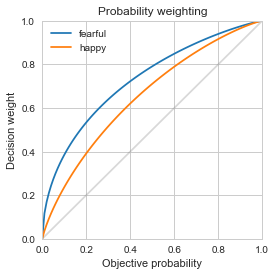

In [127]:
from mypy.viz import tableau20
from chase.cpt import w_prelec
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)


delta = .36
gamma = 1.17
axi.plot(p, w_prelec(p, delta, gamma), '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .53
gamma = 1.2
axi.plot(p, w_prelec(p, delta, gamma), '-', color=tableau20[2], label='happy')


axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,1)
plt.tight_layout()
plt.show()

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


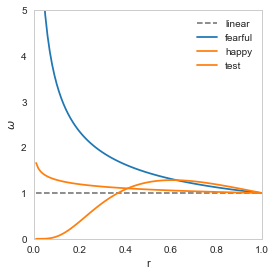

In [30]:
from mypy.viz import tableau20
from chase.cpt import w_prelec
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))

delta = 1
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '--', color='gray', label='linear')


delta = .47
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .89
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[2], label='happy')


delta = 1
gamma = 2
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[2], label='test')



axi.set_ylabel(r'$\omega$')
axi.set_xlabel('r')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,5)
axi.grid(None)
plt.tight_layout()
plt.show()

In [94]:
# derivative of weighting function
def w(p, delta, gamma):
    return (delta*gamma/p) * ((-np.log(p)) ** (gamma - 1)) * w_prelec(p, delta, gamma)

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


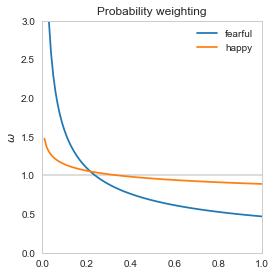

In [299]:
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [1, 1], color='gray', alpha=.3)

delta = .47
gamma = 1
axi.plot(p, w(p, delta, gamma), '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .89
gamma = 1
axi.plot(p, w(p, delta, gamma), '-', color=tableau20[2], label='happy')


axi.set_title('Probability weighting')
#axi.set_xlabel('Objective probability')
axi.set_ylabel(r'$\omega$')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,3)

axi.grid(None)
plt.tight_layout()
plt.show()

In [129]:
data['bf_cp'] = pred['cp'].values
data['ss(.25)'] = pred['ss(.25)'].values
data['ss(.5)'] = pred['ss(.5)'].values
data['ss(.75)'] = pred['ss(.75)'].values

In [130]:
for group in ['happy', 'fearful']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.bf_cp))

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = data[data.group==group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

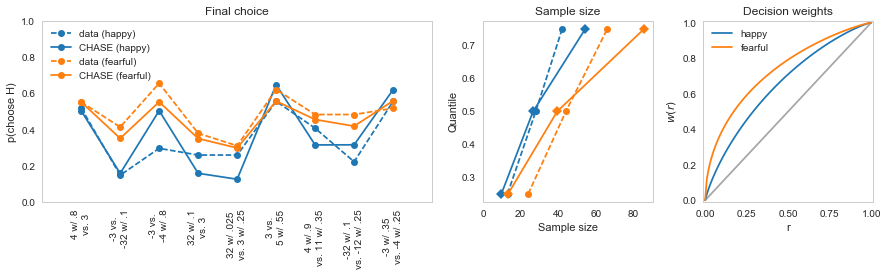

In [181]:
from mypy.viz import tableau20

n_prob = len(problems)

cols = [tableau20[0], tableau20[2]]

fig = plt.subplots(2, 2, figsize=(12.5, 4))

# choice probs
axi = plt.subplot2grid((1,4), (0,0), colspan=2)
#axi.text(-.25, 1.05, 'A', fontsize=18, fontweight='semibold', transform=axi.transAxes)
axi.plot(range(1, n_prob+1), data[data.group=='happy'].groupby('problem').apply(lambda d: np.mean(d.choice)), '--o',
         color=cols[0], label='data (happy)')
axi.plot(range(1, n_prob+1), bf_cp['happy'], '-o', color=cols[0], label='CHASE (happy)')
axi.plot(range(1, n_prob+1), data[data.group=='fearful'].groupby('problem').apply(lambda d: np.mean(d.choice)), '--o',
         color=cols[1], label='data (fearful)')
axi.plot(range(1, n_prob+1), bf_cp['fearful'], '-o', color=cols[1], label='CHASE (fearful)')
axi.set_ylim(0, 1)
axi.set_xlim(0, n_prob+1)
axi.set_xticks(range(1,n_prob+1))
axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
#axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.grid(None)
axi.set_title('Final choice')
axi.legend(loc='upper left')

# sample size
axi = plt.subplot2grid((1,4), (0,2))
axi.plot(quant['happy'], [.25, .5, .75], '--o', color=cols[0], label='data (happy)')
axi.plot(bf_quant['happy'], [.25, .5, .75], '-D', color=cols[0], label='CHASE (happy)')

axi.plot(quant['fearful'], [.25, .5, .75], '--o', color=cols[1], label='data (fearful)')
axi.plot(bf_quant['fearful'], [.25, .5, .75], '-D', color=cols[1], label='CHASE (fearful)')


axi.set_title('Sample size')
axi.set_xlim(0, 90)
#axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

#axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axi.grid(None)




p = np.arange(0, 1.01, .01)


axi = plt.subplot2grid((1,4), (0,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


delta = best['prelec_elevation(group=happy)']
gamma = best['prelec_gamma(group=happy)']
axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0], label='happy')

delta = best['prelec_elevation(group=fearful)']
gamma = best['prelec_gamma(group=fearful)']
axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[1], label='fearful')

axi.set_title('Decision weights')
axi.set_ylabel(r'$w(r)$')
axi.set_xlabel('r')
axi.legend()
axi.set_xlim(-.01,1.01)
axi.set_ylim(-.01,1.01)
axi.grid(None)

#y = -.26
#axi.plot([0, 1], [y, y], '-', clip_on=False, color='gray')
#axi.plot([.025, .1, .25, .8, 1], [y, y, y, y, y], 'D', clip_on=False, markeredgecolor='black',
#         markerfacecolor='None', markeredgewidth=1)




#axi.plot([0, 1], [1, 1], color='gray', alpha=.7)


#delta = best['prelec_elevation(group=happy)']
#gamma = best['prelec_gamma(group=happy)']
#axi.plot(p, w(p, delta, gamma), '-', color=cols[0], label='happy')

#delta = best['prelec_elevation(group=fearful)']
#gamma = best['prelec_gamma(group=fearful)']
#axi.plot(p, w(p, delta, gamma), '-', color=cols[1], label='fearful')


#axi.set_title('Attentional weights')
#axi.set_ylabel(r'$\omega$')
#axi.set_xlabel('r')
#axi.legend()
#axi.set_xlim(-.01,1.01)
#axi.set_ylim(-.01,3)
#axi.grid(None)



#y = -.75
#axi.plot([0, 1], [y, y], '-', clip_on=False, color='gray')
#axi.plot([.025, .1, .25, .8, 1], [y, y, y, y, y], 'D', clip_on=False, markeredgecolor='black',
#         markerfacecolor='None', markeredgewidth=1)


#axi.text(-.25, 1.05, 'B', fontsize=18, fontweight='semibold', transform=axi.transAxes)


plt.tight_layout()
plt.show()
fig[0].savefig('%s/fitresults_frey2014.pdf' % FIGDEST, bbox_inches='tight')

# Fit conditions indvidually

In [83]:
#OUTDIR = 'process_fitresults_FHR14'

#FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}

PARSETS = {}
PARSETS['optional'] = [#['theta', 'tau', 'c_sigma'],
                       #['theta', 'tau', 'c_sigma', 'prelec_gamma', 'prelec_elevation'],
                       ['theta', 'tau_trunc', 'c_sigma'],
                       ['theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       ]

PARSETS['geometric'] = [['p_stop_geom', 'tau', 'c_sigma'],
                        ['p_stop_geom', 'tau', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                        ]

In [66]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['geometric']:
    

    FIXED = {'minsamplesize': 2, 
             'max_T': 1000, 
             'N': 20000, 
             'stoprule': stoprule}

    for group in ['happy', 'sad', 'fearful', 'angry']:

        if stoprule == 'optional':
            SIM_ID = 'process_FHR14_%s' % group
            OUTDIR = 'process_fitresults_FHR14_%s' % group
            m = CHASEProcessModel(problems=problems,
                                  stoprule='optional')

        elif stoprule == 'geometric':
            SIM_ID = 'process_planned_FHR14_%s' % group
            OUTDIR = 'process_planned_fitresults_FHR14_%s' % group
            m = CHASEProcessModel(problems=problems,
                                  stoprule='fixedGeom')

        grpdata = data[data.group==group]
        print SIM_ID

        for fitting in PARSETS[stoprule]:

            results = fit_mlh(m, problems, grpdata, 
                              SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_planned_FHR14_happy
c_sigma	p_stop_geom	tau
[ 54.8    0.73  47.3 ] --> 2645.4	[time: 6.39]
[  60.      0.39  184.71] --> 2289.0	[time: 6.77]
[  1.26000000e+01   1.10000000e-01   1.54090000e+02] --> 1538.9	[time: 6.43]
[ 85.89   0.21  50.2 ] --> 1945.0	[time: 6.43]
[  15.22    0.17  123.91] --> 1821.3	[time: 6.34]
[  79.94    0.9   198.97] --> 2716.8	[time: 5.7]
[  2.16000000e+00   6.00000000e-02   1.30310000e+02] --> 1330.6	[time: 5.73]
[  27.24    0.73  116.9 ] --> 2649.2	[time: 6.63]
[ 10.3    0.03  27.49] --> 1270.6	[time: 6.52]
[  31.53    0.99  178.82] --> 2761.2	[time: 6.72]
[  39.89    0.55  146.31] --> 2496.7	[time: 5.74]
[ 80.85   0.16  15.55] --> 1747.6	[time: 5.76]
[ 52.16   0.79  41.1 ] --> 2674.5	[time: 5.69]
[  97.43    0.27  149.92] --> 2097.8	[time: 5.69]
[ 87.98   0.94  90.89] --> 2732.1	[time: 5.67]
[ 92.48   0.96   6.97] --> 2739.1	[time: 5.68]
[   7.64    0.37  112.75] --> 2266.4	[time: 6.4]
[ 64.72   0.87  53.71] --> 2709.5	[time: 6.24]
[ 49.88   0.57  23.0

In [84]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'sc0', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for group in ['happy', 'sad', 'fearful', 'angry']:
    
    for stoprule in ['optional', 'geometric']:
    
        if stoprule == 'optional':
            SIM_ID = 'process_FHR14_%s' % group
            OUTDIR = 'process_fitresults_FHR14_%s' % group
        elif stoprule == 'geometric':
            SIM_ID = 'process_planned_FHR14_%s' % group
            OUTDIR = 'process_planned_fitresults_FHR14_%s' % group
        FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

        
        
        for i, parset in enumerate(PARSETS[stoprule]):
            b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
            if b is not None:
                b['model'] = i
                b['dataset'] = group
                b['stoprule'] = stoprule
                results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])

In [85]:
results.sort_values(by=['dataset', 'bic'])

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,sc0,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
13,1,"process_FHR14_angry(c_sigma,prelec_elevation,p...",angry,optional,5,252,1322.876914,2673.400973,NaN,98.143473,NaN,136.350456,NaN,NaN,NaN,NaN,NaN,22.324144,NaN,NaN,NaN,1.827758,0.919730,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
12,0,"process_FHR14_angry(c_sigma,tau_trunc,theta|N=...",angry,optional,3,252,1329.633905,2675.856098,NaN,95.881956,NaN,148.311014,NaN,NaN,NaN,NaN,NaN,22.960704,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
14,0,"process_planned_FHR14_angry(c_sigma,p_stop_geo...",angry,geometric,3,252,1331.912681,2680.413650,169.633532,NaN,NaN,NaN,0.027573,NaN,NaN,NaN,NaN,73.158836,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
15,1,"process_planned_FHR14_angry(c_sigma,p_stop_geo...",angry,geometric,5,252,1328.206657,2684.060459,45.606193,NaN,NaN,NaN,0.025269,NaN,NaN,NaN,NaN,29.178382,NaN,NaN,NaN,2.649867,0.870772,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."
8,0,"process_FHR14_fearful(c_sigma,tau_trunc,theta|...",fearful,optional,3,261,1459.687498,2936.068557,NaN,24.706546,NaN,149.665401,NaN,NaN,NaN,NaN,NaN,21.173980,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
9,1,"process_FHR14_fearful(c_sigma,prelec_elevation...",fearful,optional,5,261,1458.716753,2945.256108,NaN,28.848030,NaN,146.422355,NaN,NaN,NaN,NaN,NaN,20.436597,NaN,NaN,NaN,1.084684,1.069538,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
10,0,"process_planned_FHR14_fearful(c_sigma,p_stop_g...",fearful,geometric,3,261,1468.021468,2952.736497,140.129763,NaN,NaN,NaN,0.019596,NaN,NaN,NaN,NaN,39.197717,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
11,1,"process_planned_FHR14_fearful(c_sigma,p_stop_g...",fearful,geometric,5,261,1467.061315,2961.945231,19.718255,NaN,NaN,NaN,0.021255,NaN,NaN,NaN,NaN,69.302525,NaN,NaN,NaN,1.972616,1.364455,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."
1,1,"process_FHR14_happy(c_sigma,prelec_elevation,p...",happy,optional,5,243,1237.447543,2502.360394,NaN,24.368830,NaN,128.714208,NaN,NaN,NaN,NaN,NaN,23.461028,NaN,NaN,NaN,1.370204,1.463470,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
3,1,"process_planned_FHR14_happy(c_sigma,p_stop_geo...",happy,geometric,5,243,1245.504047,2518.473401,185.793229,NaN,NaN,NaN,0.028698,NaN,NaN,NaN,NaN,19.946907,NaN,NaN,NaN,1.234976,2.100982,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."


In [81]:
tab = results[['dataset', 'stoprule', 'model', 'N', 'k', 'nllh', 'bic', 'p_stop_geom', 'theta', 'tau', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma']]
tab.to_csv('results_fits/FHR14_allmodels.csv')
tab

,dataset,stoprule,model,N,k,nllh,bic,p_stop_geom,theta,tau,tau_trunc,c_sigma,prelec_elevation,prelec_gamma
0,happy,optional,0,243,3,1254.484080,2525.447344,NaN,125.756560,NaN,14.981689,24.985480,NaN,NaN
1,happy,optional,1,243,5,1237.447543,2502.360394,NaN,128.714208,NaN,24.368830,23.461028,1.370204,1.463470
2,happy,geometric,0,243,3,1259.757005,2535.993195,0.032978,NaN,193.958585,NaN,28.618574,NaN,NaN
3,happy,geometric,1,243,5,1245.504047,2518.473401,0.028698,NaN,185.793229,NaN,19.946907,1.234976,2.100982
4,sad,optional,0,252,3,1355.381938,2727.352162,NaN,115.702008,NaN,29.229323,18.714768,NaN,NaN
5,sad,optional,1,252,5,1332.981409,2693.609963,NaN,130.316107,NaN,26.823869,19.817246,1.977634,0.878634
6,sad,geometric,0,252,3,1357.033400,2730.655088,0.023524,NaN,194.384097,NaN,44.573468,NaN,NaN
7,sad,geometric,1,252,5,1345.606712,2718.860570,0.026394,NaN,157.686220,NaN,29.507589,2.299460,1.107787
8,fearful,optional,0,261,3,1459.687498,2936.068557,NaN,149.665401,NaN,24.706546,21.173980,NaN,NaN
9,fearful,optional,1,261,5,1458.716753,2945.256108,NaN,146.422355,NaN,28.848030,20.436597,1.084684,1.069538


In [89]:
fitting = PARSETS['optional'][1]
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    OUTDIR = 'process_fitresults_FHR14_%s' % group
    
    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR)
    print best[group]

/Users/markant/code/chase/chase/cpt.py:40: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))
process_model.py:94: RuntimeWarning: invalid value encountered in divide
  omega.append(weights[i]/option[:,1])


index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1237.45
k                                                                   5
N                                                                 243
bic                                                           2502.36
c_sigma                                                        23.461
prelec_elevation                                               1.3702
prelec_gamma                                                  1.46347
tau_trunc                                                     24.3688
theta                                                         128.714
sim_id              process_FHR14_happy(c_sigma,prelec_elevation,p...
Name: 0, dtype: obje

In [90]:
cp = {}
bf_cp = {}
quant = {}
bf_quant = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group].groupby('problem').apply(lambda d: np.mean(d.pred_cp))

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean()

In [51]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


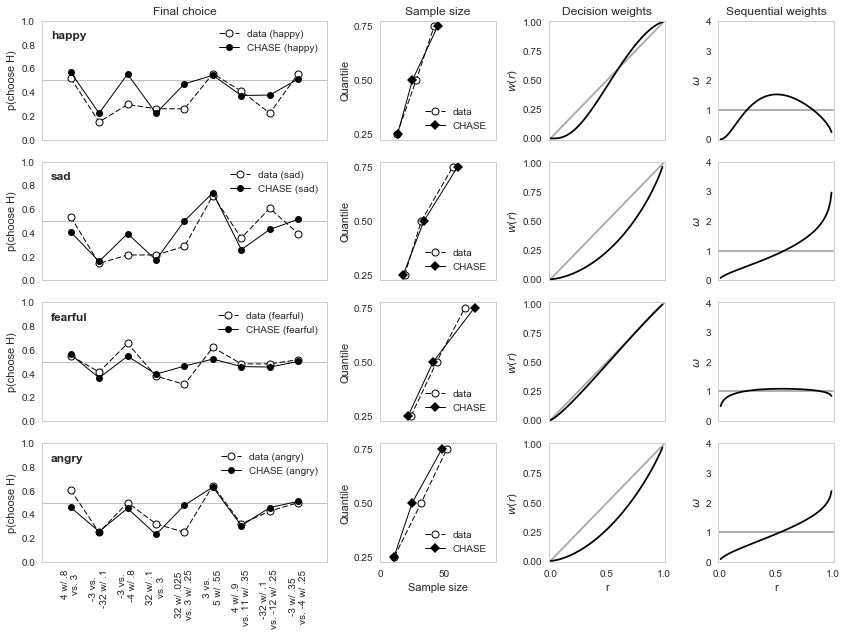

In [102]:
n_prob = len(problems)

fig = plt.subplots(4, 5, figsize=(12, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,5), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,5), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    axi.set_yticks([.25,.5,.75])
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1, .01)

    axi = plt.subplot2grid((4,5), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Decision weights')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)


    axi = plt.subplot2grid((4,5), (j,4))
    axi.plot([0, 1], [1, 1], color='gray', alpha=.7)
    if j == 0: axi.set_title('Sequential weights')

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w(p, delta, gamma), '-', color=cols[0])
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,4.01)
    axi.grid(None)
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.set_ylabel('$\omega$')



plt.tight_layout()
plt.show()
fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [55]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'c_sigma', 'tau_trunc', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups
fitdf['dataset'] = 'FHR14'
fitdf['stoprule'] = 'optional'
fitdf['model'] = 0

In [56]:
fitdf

,index,nllh,k,N,bic,theta,c_sigma,tau_trunc,prelec_elevation,prelec_gamma,group,dataset,stoprule,model
0,0,1237.447543,5,243,2502.360394,128.714208,23.461028,24.368830,1.370204,1.463470,happy,FHR14,optional,0
1,0,1332.981409,5,252,2693.609963,130.316107,19.817246,26.823869,1.977634,0.878634,sad,FHR14,optional,0
2,0,1458.716753,5,261,2945.256108,146.422355,20.436597,28.848030,1.084684,1.069538,fearful,FHR14,optional,0
3,0,1322.876914,5,252,2673.400973,136.350456,22.324144,98.143473,1.827758,0.919730,angry,FHR14,optional,0


In [59]:
tab = fitdf[['dataset', 'group', 'stoprule', 'model', 'N', 'k', 'nllh', 'bic', 'theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma']]
tab.to_csv('results_fits/FHR14_bestmodel.csv')

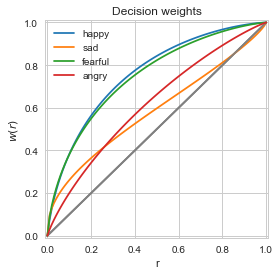

In [205]:
p = np.arange(0, 1.01, .01)

fig, axi = plt.subplots(figsize=(4,4))

for i, group in enumerate(['happy', 'sad', 'fearful', 'angry']):

    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[i], label=group)

    axi.set_title('Decision weights')
    axi.set_ylabel(r'$w(r)$')
    axi.set_xlabel('r')
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)
plt.show()

# Fit conditions individually (p_switch)

In [46]:
SWITCH_RATE = {'happy': .08,
               'fearful': .04,
               'angry': .06,
               'sad': .05}

In [47]:
OUTDIR = 'process_fitresults_FHR14_pswitch'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000, 'switchfirst': True}

PARSETS = [#['theta', 'tau'],
           #['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [48]:
#for group in ['happy', 'sad', 'fearful', 'angry']:
for group in ['fearful']:
    
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    print SIM_ID
    
    FIXED['p_switch'] = SWITCH_RATE[group]
    
    for fitting in PARSETS:

        results = fit_mlh(m, problems, grpdata, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_FHR14_fearful
pow_gain	prelec_elevation	prelec_gamma	tau	theta


process_model.py:78: RuntimeWarning: invalid value encountered in divide
  w_outcomes[0] = w_outcomes[0] - phi
process_model.py:364: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  'traces': traces
process_model.py:349: RuntimeWarning: invalid value encountered in divide
  sampled_option = [sampled_option[i][:(samplesize[i]+1)] for i in range(samplesize.shape[0])]


[  5.90000000e-02   1.48800000e+00   1.69300000e+00   9.73010000e+01
   4.30870000e+01] 1901.71549984
[  0.994   1.455   2.641  46.069  10.197] 2266.38915113
[  0.295   0.144   2.696  39.813  22.073] 1571.54588224
[  1.265   2.521   2.004   7.395  16.527] 2246.8603616
[  1.143   2.446   2.497  60.369  38.625] 2036.64193842
[  1.539   0.535   2.917  27.394  16.79 ] 2252.90188555
[  1.106   2.014   1.921  95.318  23.739] 2049.26669106
[  1.855   2.786   1.329  88.11    9.899] 2272.8838951
[  0.882   0.864   2.953  29.926  34.821] 1847.00400728
[  1.041   2.432   0.071   2.566  33.086] 1690.88030303
[  1.656   0.807   1.884  33.564  35.864] 2226.40699979
[  0.575   2.313   1.137  12.231  40.145] 1861.40266741
[  0.851   2.235   0.575  25.113   2.502] 2415.69700972
[  0.509   1.736   0.175  62.824  42.24 ] 1617.89013566
[  0.669   2.329   1.253  77.598  48.047] 1877.60862315
[  1.80000000e-02   1.84100000e+00   2.00000000e-02   5.71320000e+01
   1.11810000e+01] 1624.62845695
[  8.80000000e

process_model.py:346: RuntimeWarning: invalid value encountered in divide
  outcome_ind = None


[  1.621   2.848   0.121  74.226   0.297] 2762.88932285
[  0.945   1.624   0.321  41.452  31.64 ] 1636.37854784
[  1.198   0.107   0.899  73.244  21.946] 2309.49597582
[  1.577   0.647   2.049  31.635  37.301] 2177.39507421
[  1.169   1.557   0.719  83.898   6.077] 2414.44956556
[  1.474   1.351   2.806  37.789  17.897] 2283.21194892
[  0.773   0.481   0.24   89.414   6.55 ] 2440.0207708
[  1.405   0.336   0.372  23.995  30.693] 2211.39757979
[  1.574   2.18    1.761  14.478  12.08 ] 2300.6597186
[  0.435   0.753   1.8    36.971  26.666] 1621.97162395
[  0.178   1.367   0.445  62.617  34.694] 1655.65228004
[  1.37    0.308   0.533  84.63   48.857] 1983.16218448
[  0.787   0.668   2.538  93.345  29.443] 1800.45257493
[  1.082   1.678   1.23    5.028  36.036] 1714.8785503
[  0.916   2.989   2.858  57.37   40.957] 2085.09847514
[  1.97700000e+00   4.80000000e-02   7.59000000e-01   6.49250000e+01
   3.77140000e+01] 2437.66023843
[  0.142   2.057   2.999  59.846  46.304] 2062.92381751
[  1.

KeyboardInterrupt: 

In [35]:
fitting = PARSETS[0]

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    FIXED['p_switch'] = SWITCH_RATE[group]

    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR)
    print best[group]

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1241.47
k                                                                   5
N                                                                 243
bic                                                            2510.4
pow_gain                                                    0.0285693
prelec_elevation                                             0.269865
prelec_gamma                                                  1.38986
tau                                                           43.0577
theta                                                         13.6943
sim_id              process_FHR14_happy(pow_gain,prelec_elevation,...
Name: 0, dtype: obje

In [42]:
for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group]['cp']

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

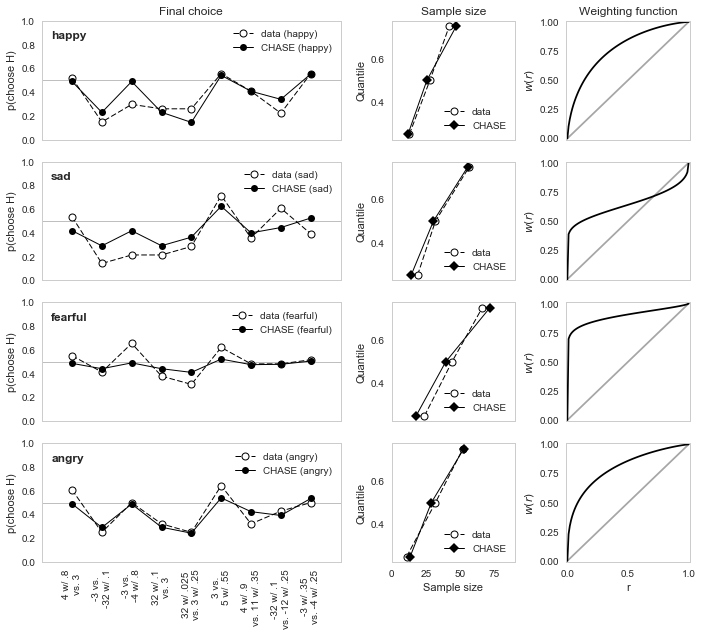

In [43]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

n_prob = len(problems)

fig = plt.subplots(4, 4, figsize=(10, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,4), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,4), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    #axi.legend(loc='upper left')
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1.01, .01)


    axi = plt.subplot2grid((4,4), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Weighting function')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)



plt.tight_layout()
plt.show()
#fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [44]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'tau', 'pow_gain', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups

In [45]:
fitdf

,index,nllh,k,N,bic,theta,tau,pow_gain,prelec_elevation,prelec_gamma,group
0,0,1241.466137,5,243,2510.397581,13.694268,43.057746,0.028569,0.269865,1.389858,happy
1,0,1338.550289,5,252,2704.747724,15.702699,39.786267,0.012799,0.518055,0.395953,sad
2,0,1459.521819,5,261,2946.866241,28.370094,48.000452,0.044146,0.126165,0.688497,fearful
3,0,1322.364975,5,252,2672.377096,16.568555,52.557158,0.011750,0.235685,1.198122,angry
